In [5]:
import uproot
import numpy as np
import ROOT
import itertools
from array import array
ROOT.gROOT.SetStyle('ATLAS')
import time
import os
from IPython.display import Image, display

def draw_note(x, y, text, size=35, font=63):
    l = ROOT.TLatex()
    l.SetNDC()
    l.SetTextColor(1)
    l.SetTextFont(font)
    l.SetTextSize(size);
    l.DrawLatex(x, y, text)

def atlas_label(x, y, text=None, color=1):
    draw_note(x, y, r"#bf{#it{ATLAS}} " + text)

FONT_SIZE = 30

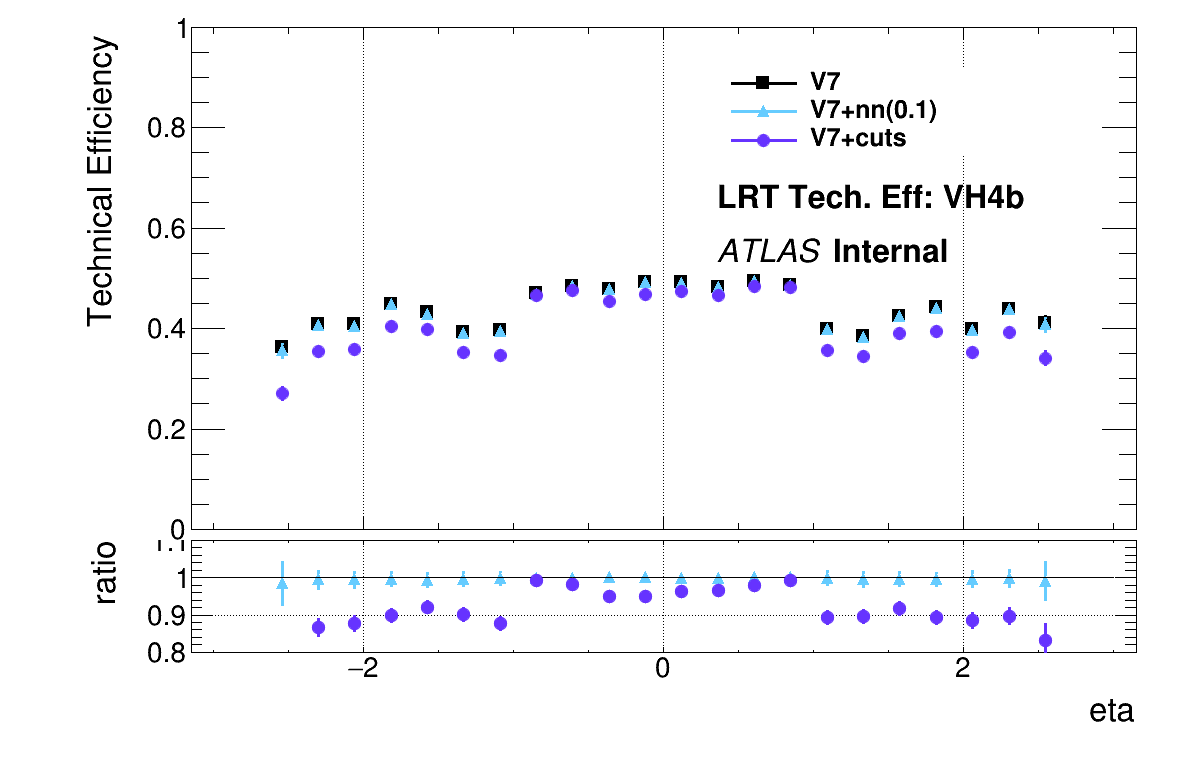

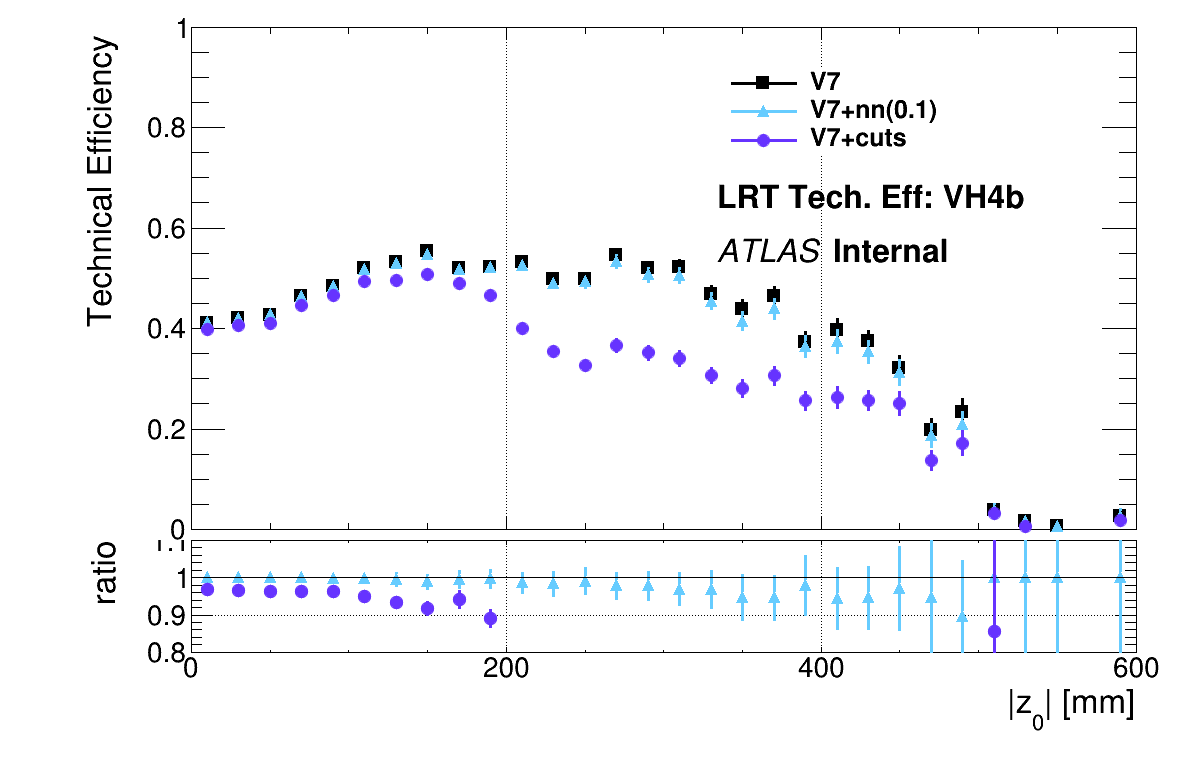

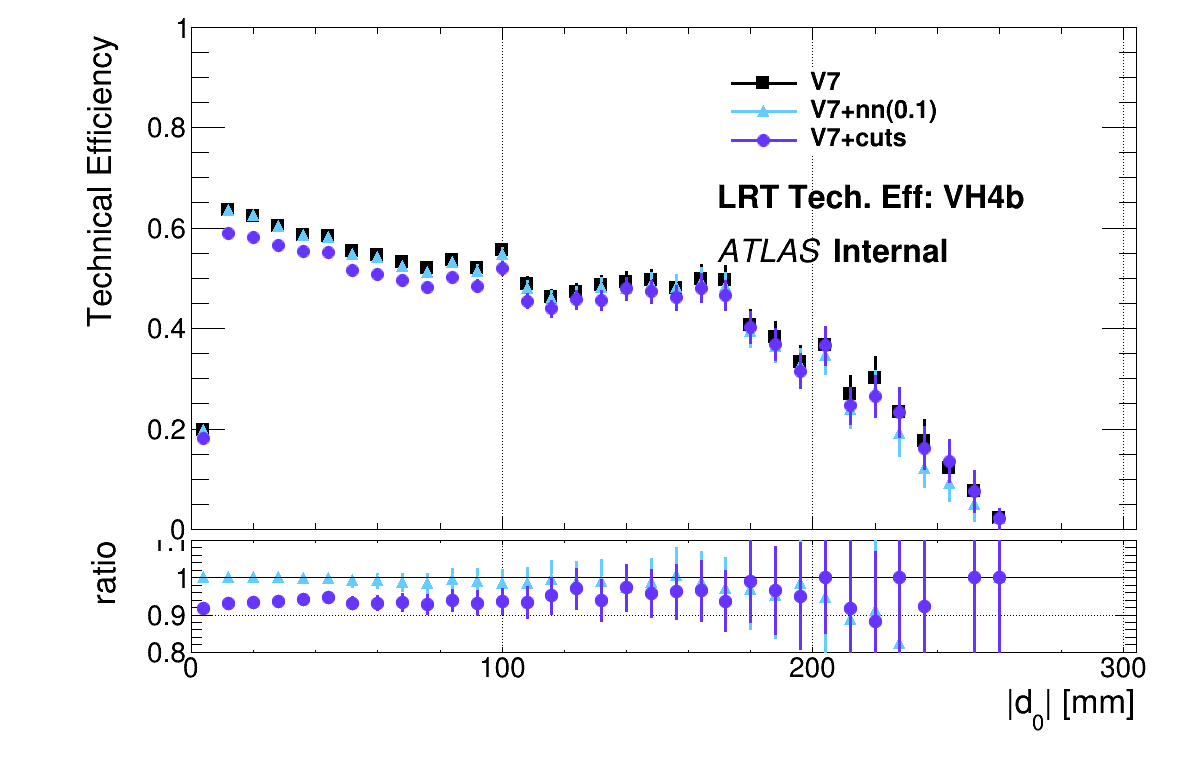

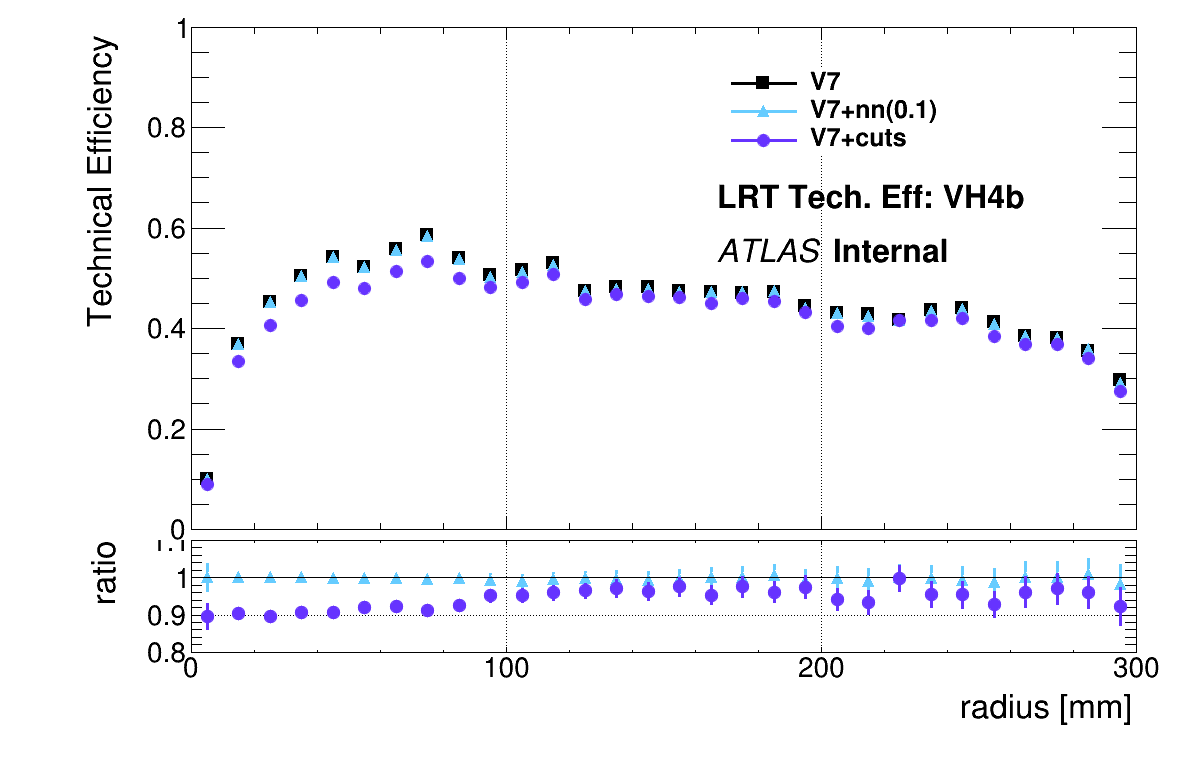

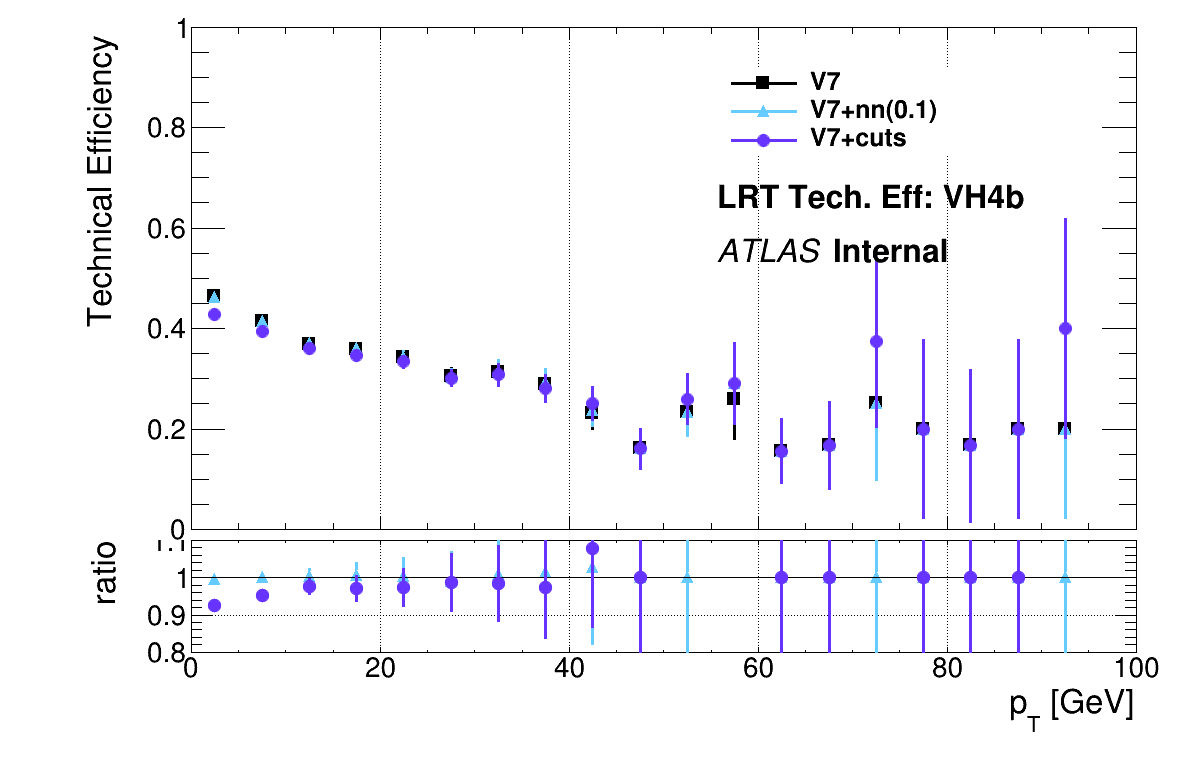

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nnp1_hardcuts/VH4b/tech_eff_comparison_truth_eta.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nnp1_hardcuts/VH4b/tech_eff_comparison_truth_eta.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nnp1_hardcuts/VH4b/tech_eff_comparison_truth_absz0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nnp1_hardcuts/VH4b/tech_eff_comparison_truth_absz0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nnp1_hardcuts/VH4b/tech_eff_comparison_truth_absd0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatth

In [78]:
signal = 'VH4b'
# signal = 'HNL'
# signal = 'RPVLF'
# signal = 'TTBAR'

variables = {
    'truth_eta' :   {'bounds' : (-3,3),    'label': 'eta', 'log' : False,},
    'truth_absz0' : {'bounds' : (0,600), 'label': '|z_{0}| [mm]', 'log' : False,},
    'truth_absd0' : {'bounds' : (0,300),   'label': '|d_{0}| [mm]', 'log' : False,},
    'truth_r' :     {'bounds' : (0,300),  'label': 'radius [mm]', 'log' : False,},
    'truth_pt' :    {'bounds' : (0,100),   'label': 'p_{T} [GeV]', 'log' : False,},
}
output_dir = f"/data/newhouse/LRT/forMatthias/plots/v7_nnp1_hardcuts/{signal}/"
os.makedirs(output_dir, exist_ok=True)

for var, options in variables.items():

    tree_name = 'Efficiency'
    tree1 = 'v7'
    tree2 = 'v7_nn'
    tree3 = 'v7_hardcuts'
    # Open file
    tfiles = {
              tree1: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{signal}_V7.root'),
              tree2: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{signal}_V7nn_p1.root'),
              tree3: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/plots/Efficiency_files_{signal}_hardcuts.root'),
             }
    
    # Load tree from file
    ttree = {}
    for key, val in tfiles.items():
        ttree[key] = val.Get(tree_name)

    hist = {}
    for key, val in ttree.items():
        hist[key] = val.Get(var)
        
    # define colors and markers
    stlye = {
        tree1: {'marker': 21, 'color': ROOT.kBlack},
        tree2: {'marker': 22, 'color': ROOT.kAzure+6},
        tree3: {'marker': 20, 'color': ROOT.kViolet+8},
    }

    # Upper plot will be in pad1
    c = None
    scale = 1.0
    c = ROOT.TCanvas("c", "", int(1200*scale), int(800*scale))

    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.02);  # Upper and lower plot are not joined
    pad1.SetGridx();          # Vertical grid
    pad1.Draw();              # Draw the upper pad: pad1
    pad1.cd();                # pad1 becomes the current pad

        
    # Set draw properties
    for key, h in hist.items():
        # Histogram properties
        h.SetMarkerSize(1.7*scale)
        h.SetLineWidth(int(3*scale))
        h.SetLineColor(stlye[key]['color'])
        h.SetMarkerColor(stlye[key]['color'])
        h.SetMarkerStyle(stlye[key]['marker'])
        # X axis
        h.GetXaxis().SetRangeUser(options['bounds'][0], options['bounds'][1]);
        h.GetXaxis().SetLabelSize(0);
        h.GetXaxis().SetTitle(options['label'])
        h.GetYaxis().SetTitle("Technical Efficiency")
        # Y axis
        h.GetYaxis().SetMaxDigits(6);
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetRangeUser(0,1);
        h.GetYaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetLabelSize(FONT_SIZE);   
        h.GetYaxis().SetTitleFont(43)  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetTitleSize(FONT_SIZE*1.2)
    
        h.Draw("SAME")

    c.cd();
    # format legend
    x = 0.6
    y = 0.8
    leg = ROOT.TLegend(x, 0.8, 0.91, 0.91)
    leg.SetTextSize(0.035)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    for h, label in zip(hist.values(), ["V7", "V7+nn(0.1)", "V7+cuts"]) :
        leg.AddEntry(h, label, "lp")
    dy = .07
    draw_note(x, y-dy, f'LRT Tech. Eff: {signal}')
    atlas_label(x,y-2*dy, 'Internal')
#     draw_note(x, y-3*dy, signal)
    leg.Draw()


    # lower plot will be in pad 2
    c.cd();          # Go back to the main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.42)
    pad2.SetGridx() # vertical grid
    pad2.SetGridy() # horizontal grid
    pad2.Draw()
    pad2.cd() # pad2 becomes the current pad
    pad2.SetFillStyle(0)
    
    hr = {}
    for key, h in hist.items():
        if key == tree1: continue
        # Define the ratio plot
        hr[key] = h.Clone("h3"+key)
        hr[key] = h.Clone("h3"+key);
        hr[key].SetLineColor(stlye[key]['color']);
        hr[key].SetMarkerStyle(stlye[key]['marker']);
        hr[key].SetMinimum(0.8);  # Define Y ..
        hr[key].SetMaximum(1.1); # .. range

        hr[key].Divide(hist[tree1]);

        hline = ROOT.TLine(options['bounds'][0], 1, options['bounds'][1], 1)
        hr[key].Draw("ep same") # Draw the ratio plot 
        hline.Draw("Same")
        hr[key].Draw("ep Same") # Draw the ratio plot 

        # Y axis ratio plot settings
        hr[key].GetYaxis().SetTitle("ratio")
        hr[key].GetYaxis().SetNdivisions(505)
        hr[key].GetYaxis().SetTitleSize(FONT_SIZE*1.2)
        hr[key].GetYaxis().SetTitleFont(43)
        hr[key].GetYaxis().SetTitleOffset(1.0)
        hr[key].GetYaxis().SetLabelFont(43)  # Absolute font size in pixel (precision 3)
        hr[key].GetYaxis().SetLabelSize(FONT_SIZE)
        # X axis ratio plot settings
        hr[key].GetXaxis().SetTitleSize(FONT_SIZE*1.2);
        hr[key].GetXaxis().SetTitleFont(43);
        hr[key].GetXaxis().SetTitleOffset(4.);
        hr[key].GetXaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        hr[key].GetXaxis().SetLabelSize(FONT_SIZE);  
    
    
#     c.Draw()
    image_file = f'{output_dir}tech_eff_comparison_{var}.png'
    c.SaveAs(image_file)
    c.SaveAs(image_file.replace('png', 'pdf'))
    display(Image(filename=image_file))

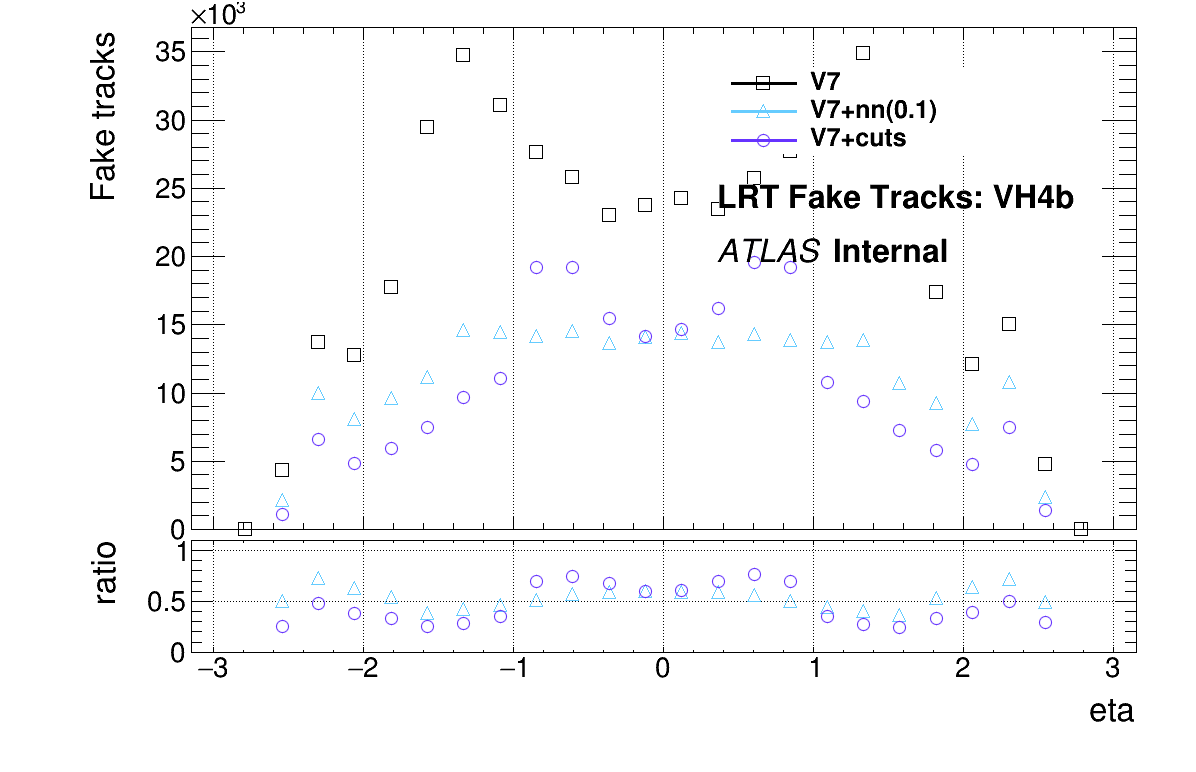

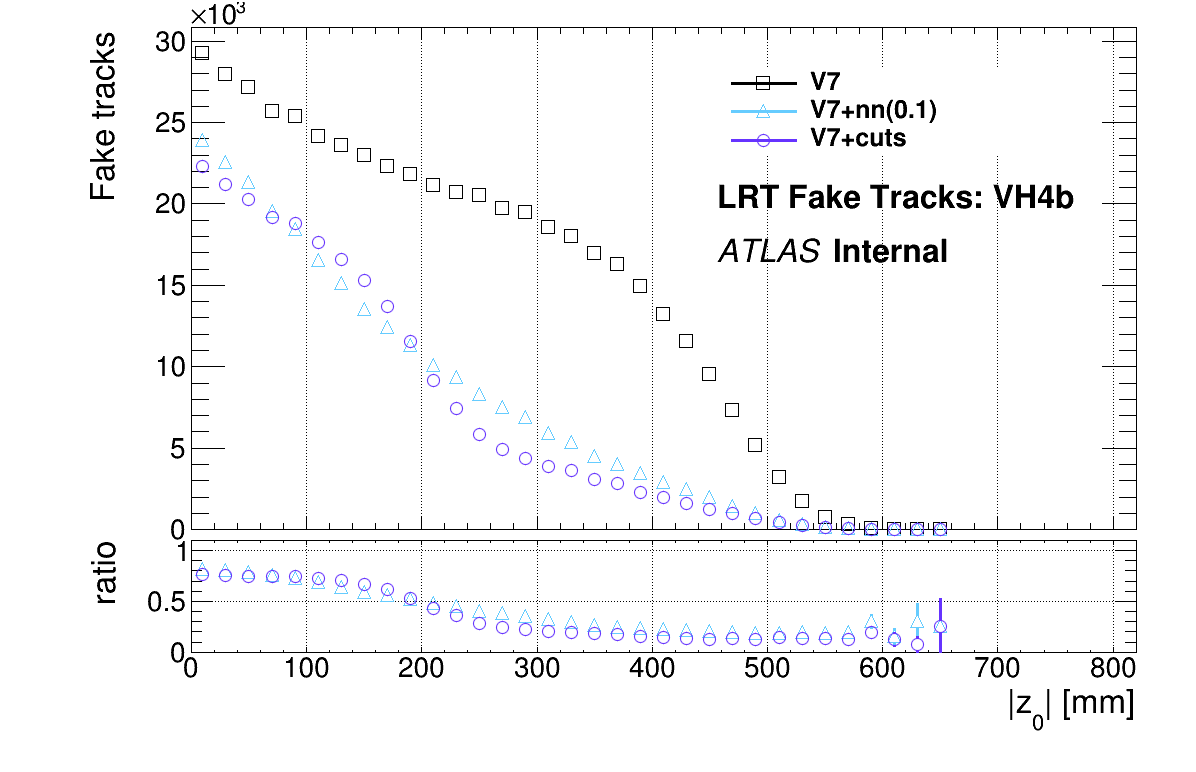

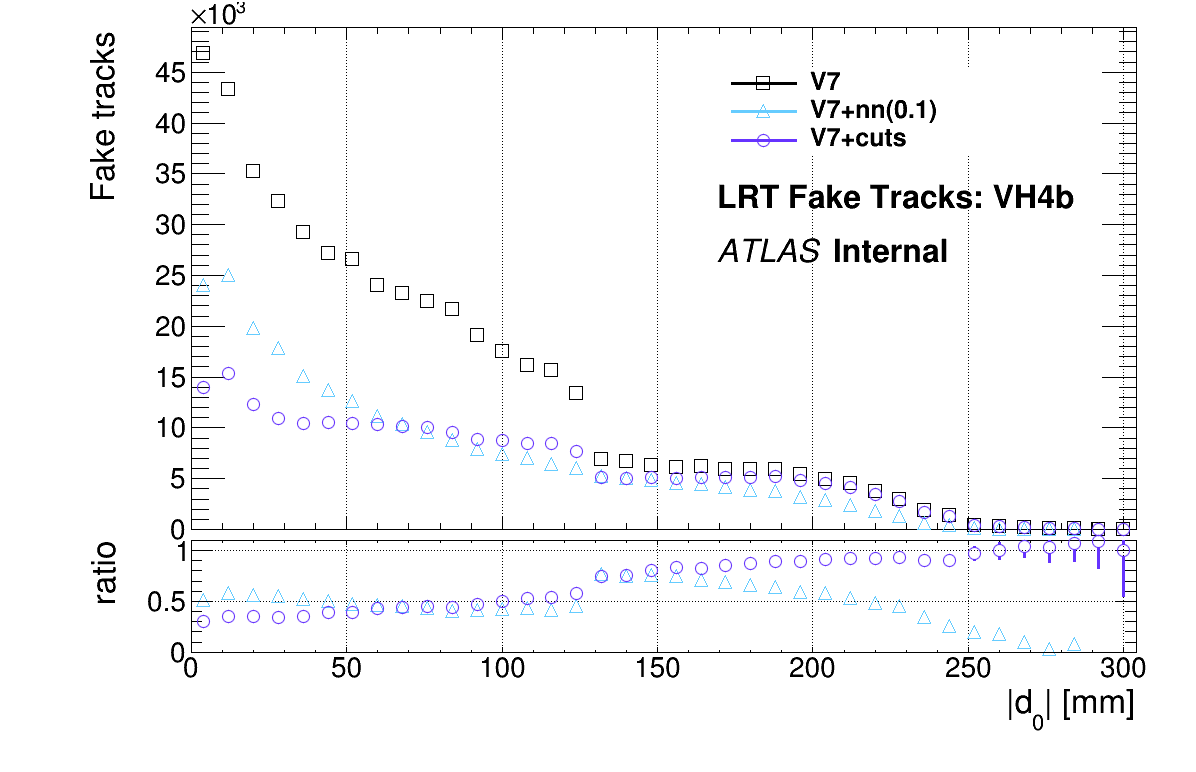

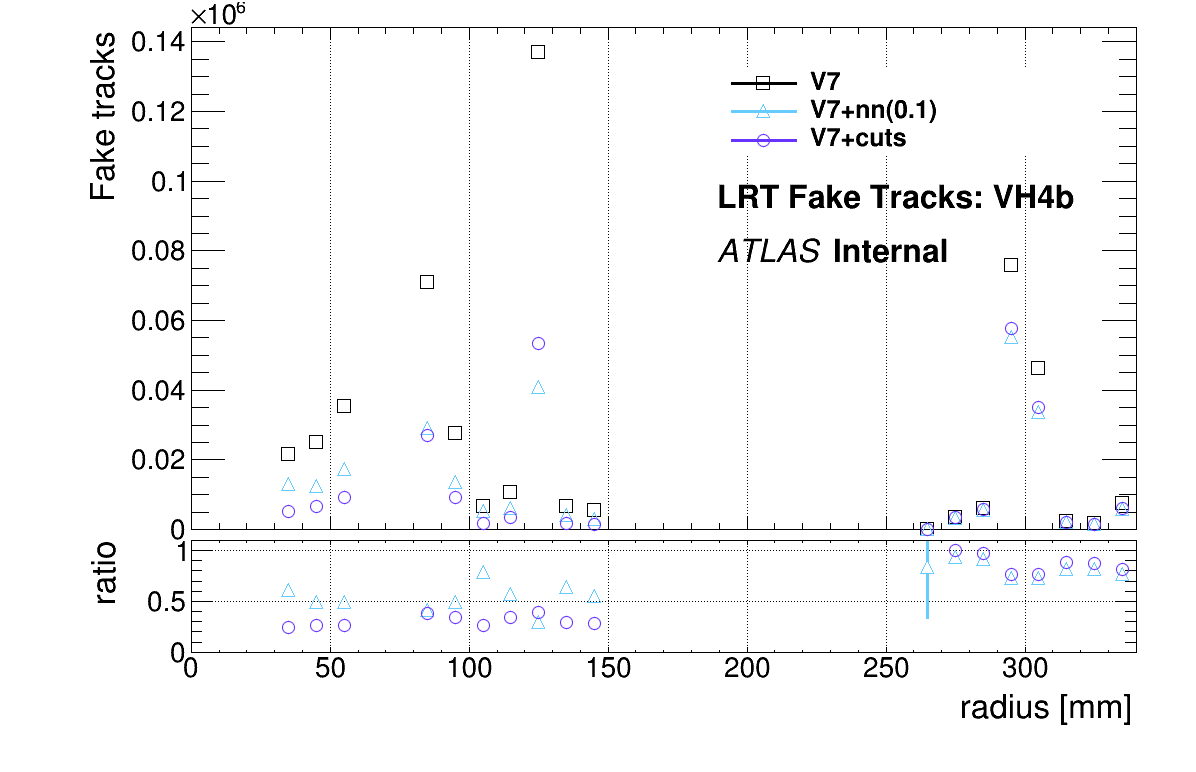

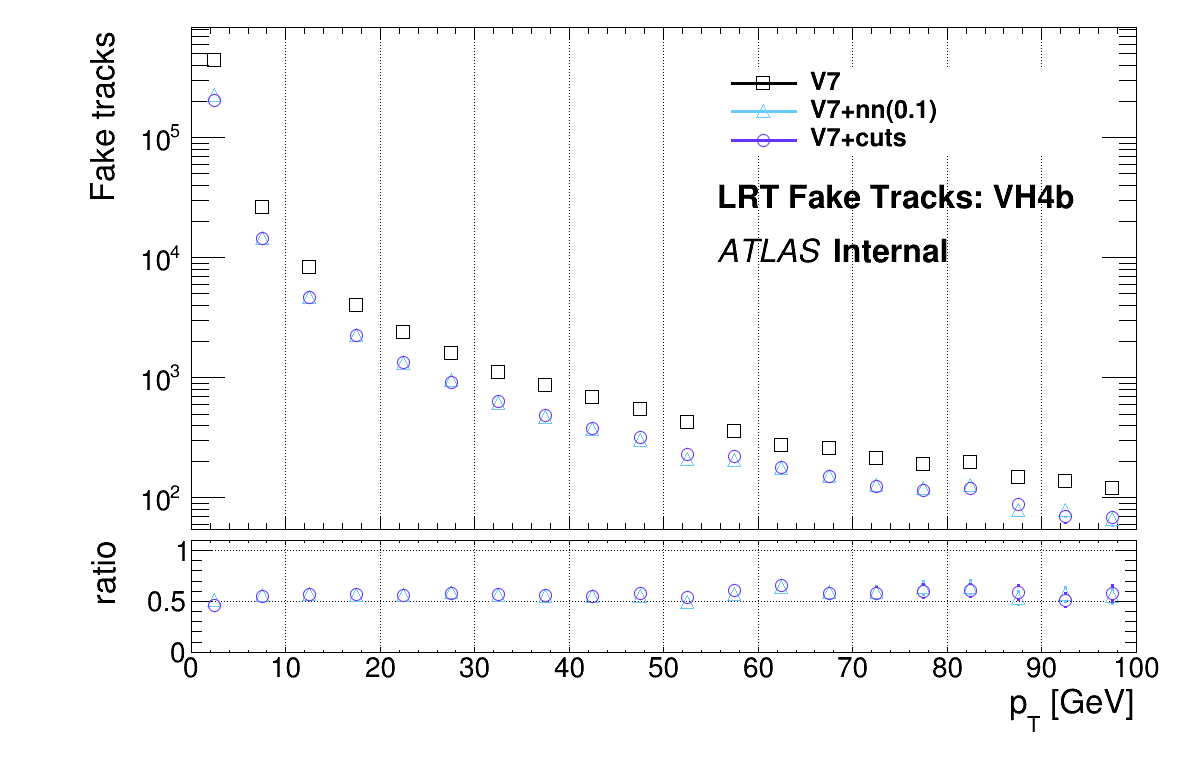

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nnp2_hardcuts/VH4b/fakes_track_eta.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nnp2_hardcuts/VH4b/fakes_track_eta.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nnp2_hardcuts/VH4b/fakes_track_absz0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nnp2_hardcuts/VH4b/fakes_track_absz0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /data/newhouse/LRT/forMatthias/plots/v7_nnp2_hardcuts/VH4b/fakes_track_absd0.png has been created
Info in <TCanvas::Print>: pdf file /data/newhouse/LRT/forMatthias/plots/v7_nnp2_hardcuts/VH4b/fakes_track_absd0.pdf has been created

In [77]:
# Make fake comparison plot

variables = {
    'track_eta' :   {'bounds' : (-3,3),    'label': 'eta', 'log' : False,},
    'track_absz0' : {'bounds' : (0,10000), 'label': '|z_{0}| [mm]', 'log' : False,},
    'track_absd0' : {'bounds' : (0,300),   'label': '|d_{0}| [mm]', 'log' : False,},
    'track_r' :     {'bounds' : (0,1000),  'label': 'radius [mm]', 'log' : False,},
    'track_pt' :    {'bounds' : (0,100),   'label': 'p_{T} [GeV]', 'log' : True,},
}
# output_dir = f"/home/newhouse/public/Analysis/LRT/lrtanalysis/run/NN_func/{signal}/"
# os.makedirs(output_dir, exist_ok=True)

for var, options in variables.items():

    tree_name = 'TrackIsFakeIsLRTPassSelection0'
    tree1 = 'v7'
    tree2 = 'v7_nn'
    tree3 = 'v7_hardcuts'
    # Open file
    tfiles = {
              tree1: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{signal}_V7.root'),
              tree2: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{signal}_V7nn_p1.root'),
              tree3: ROOT.TFile(f'/home/newhouse/public/Analysis/LRT/lrtanalysis/run/output/files_{signal}_hardcuts.root'),
             }


    # Load tree from file
    ttree = {}
    for key, val in tfiles.items():
        ttree[key] = val.Get(tree_name)

    hist = {}
    for key, val in ttree.items():
        hist[key] = val.Get(var)
        
    # define colors and markers
    stlye = {
        tree1: {'marker': 25, 'color': ROOT.kBlack},
        tree2: {'marker': 26, 'color': ROOT.kAzure+6},
        tree3: {'marker': 24, 'color': ROOT.kViolet+8},
    }

    
    # Upper plot will be in pad1
    c = None
    scale = 1.0
    c = ROOT.TCanvas("c", "", int(1200*scale), int(800*scale))

    pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.02);  # Upper and lower plot are not joined
    pad1.SetGridx();          # Vertical grid
    pad1.Draw();              # Draw the upper pad: pad1
    pad1.cd();                # pad1 becomes the current pad
    
    if options['log']:
        pad1.SetLogy()

    # Set draw properties
    for key, h in hist.items():
        # Hist options
        h.SetMarkerSize(1.7*scale)
        h.SetLineWidth(int(3*scale))
        h.SetLineColor(stlye[key]['color'])
        h.SetMarkerColor(stlye[key]['color'])
        h.SetMarkerStyle(stlye[key]['marker'])
        # X axis
        h.GetXaxis().SetRangeUser(options['bounds'][0], options['bounds'][1]);
        h.GetXaxis().SetLabelSize(0);
        h.GetXaxis().SetTitle(options['label'])
        # Y axis
        h.GetYaxis().SetTitle("Fake tracks")
        h.GetYaxis().SetMaxDigits(3);
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetLabelSize(FONT_SIZE);   
        h.GetYaxis().SetTitleFont(43)  # Absolute font size in pixel (precision 3)
        h.GetYaxis().SetTitleSize(FONT_SIZE*1.2)

        h.Draw("E1 Same")
    
    # format legend
    c.cd(); 
    x = 0.6
    y = 0.8
    leg = ROOT.TLegend(x, 0.8, 0.91, 0.91)
    leg.SetTextSize(0.035)
    leg.SetBorderSize(0)
    leg.SetFillColor(ROOT.kWhite)
    leg.SetShadowColor(ROOT.kWhite)
    for h, label in zip(hist.values(), ["V7", "V7+nn(0.1)", "V7+cuts"]) :
        leg.AddEntry(h, label, "lp")
    dy = .07
    draw_note(x, y-dy, f'LRT Fake Tracks: {signal}')
    atlas_label(x,y-2*dy, 'Internal')
#     draw_note(x, y-3*dy, signal)
    leg.Draw()

    
    # lower plot will be in pad 2
    c.cd();          # Go back to the main canvas before defining pad2
    pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.42)
    pad2.SetGridx() # vertical grid
    pad2.SetGridy() # horizontal grid
    pad2.Draw()
    pad2.cd() # pad2 becomes the current pad
    
    
    hr = {}
    for key, h in hist.items():
        if key == tree1: continue
        # Define the ratio plot
        hr[key] = h.Clone("h3"+key)
        hr[key] = h.Clone("h3"+key);
        hr[key].SetLineColor(stlye[key]['color']);
        hr[key].SetMarkerStyle(stlye[key]['marker']);
        hr[key].SetMinimum(0.0);  # Define Y ..
        hr[key].SetMaximum(1.1); # .. range

        hr[key].Divide(hist[tree1]);

#         hline = ROOT.TLine(options['bounds'][0], 1, options['bounds'][1], 1)
#         hr[key].Draw("ep same") # Draw the ratio plot 
#         hline.Draw("Same")
        hr[key].Draw("ep Same") # Draw the ratio plot 

        # Y axis ratio plot settings
        hr[key].GetYaxis().SetTitle("ratio")
        hr[key].GetYaxis().SetNdivisions(505)
        hr[key].GetYaxis().SetTitleSize(FONT_SIZE*1.2)
        hr[key].GetYaxis().SetTitleFont(43)
        hr[key].GetYaxis().SetTitleOffset(1.0)
        hr[key].GetYaxis().SetLabelFont(43)  # Absolute font size in pixel (precision 3)
        hr[key].GetYaxis().SetLabelSize(FONT_SIZE)
        # X axis ratio plot settings
        hr[key].GetXaxis().SetTitleSize(FONT_SIZE*1.2);
        hr[key].GetXaxis().SetTitleFont(43);
        hr[key].GetXaxis().SetTitleOffset(4.);
        hr[key].GetXaxis().SetLabelFont(43);  # Absolute font size in pixel (precision 3)
        hr[key].GetXaxis().SetLabelSize(FONT_SIZE);  
    

    image_file = f'{output_dir}fakes_{var}.png'
    c.SaveAs(image_file)
    c.SaveAs(image_file.replace('png', 'pdf'))
    display(Image(filename=image_file))